In [1]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 903 kB 5.1 MB/s 


In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
from scipy.stats.distributions import chi2


In [3]:
raw_csv_data = pd.read_csv('Index2018.csv')
df_comp = raw_csv_data.copy()
df_comp['date'] = pd.to_datetime(df_comp['date'], dayfirst = True)
df_comp.set_index('date',inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

In [4]:
df_comp['market_value'] = df_comp.ftse

In [5]:
del df_comp['dax']
del df_comp['ftse']
del df_comp['nikkei']
del df_comp['spx']

size = int(len(df_comp)*0.8)
df,df_test = df_comp.iloc[:size],df_comp.iloc[size:]

In [6]:
def LLR_test(mod1,mod2,DF=1):
   L1 = mod1.fit().llf
   L2 = mod2.fit().llf
   LR = (2*(L2-L1))
   p = chi2.sf(LR,DF).round(3)
   return p

In [7]:
df['returns'] = df['market_value'].pct_change(1).mul(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


# Creating Squared Returns

In [8]:
df['squared_returns'] = df.returns.mul(df.returns)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
df.head()

,market_value,returns,squared_returns
date,,,
1994-01-07,3445.98,NaN,NaN
1994-01-10,3440.58,-0.156704,0.024556
1994-01-11,3413.77,-0.779229,0.607198
1994-01-12,3372.02,-1.222988,1.495700
1994-01-13,3360.01,-0.356166,0.126854


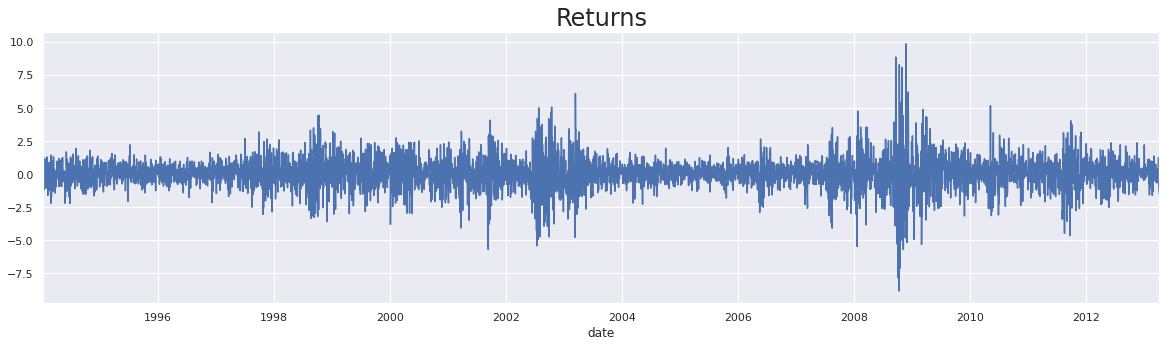

In [10]:
df.returns.plot(figsize=(20,5))
plt.title('Returns',size=24)
plt.show()

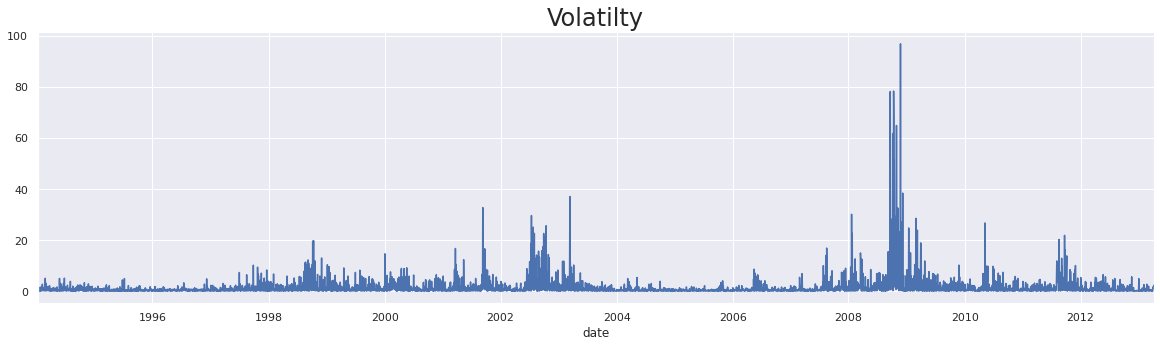

In [11]:
df.squared_returns.plot(figsize=(20,5))
plt.title('Volatilty',size=24)
plt.show()

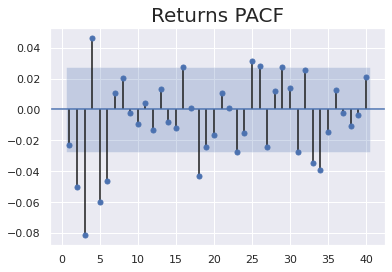

In [12]:
sgt.plot_pacf(df.returns[1:], lags = 40,method='ols',zero=False)
plt.title('Returns PACF',size=20)
plt.show()

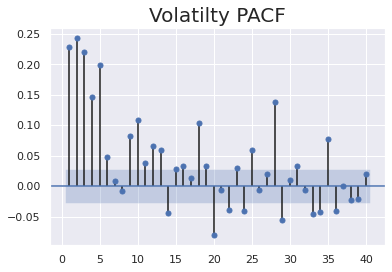

In [13]:
sgt.plot_pacf(df.squared_returns[1:], lags = 40,method='ols',zero=False)
plt.title('Volatilty PACF',size=20)
plt.show()

# The arch_model() Method

In [14]:
model_arch1 = arch_model(df.returns[1:])
results_arch1 = model_arch1.fit()
results_arch1.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6579303469.390623
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2701100877.2298183
Iteration:      3,   Func. Count:     23,   Neg. LLF: 7009.030632045198
Iteration:      4,   Func. Count:     29,   Neg. LLF: 7024.035835212278
Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6975.418108744094
Iteration:      7,   Func. Count:     47,   Neg. LLF: 7092.271338807877
Iteration:      8,   Func. Count:     53,   Neg. LLF: 6973.879266228052
Iteration:      9,   Func. Count:     59,   Neg. LLF: 6970.088048943886
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Iteration:     11,   Func. Count:     69,   Neg. LLF: 6970.0583674757745
Iteration:     12,   Func. Count:     74,   Neg. LLF: 6970.058366189882
Iteration:     13,   Func. Count:     78,   Neg. LLF: 6970.058366189167
Optimization terminated successfully    (Exit mode 0)
        

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        07:45:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## Simple ARCH(1) Model

In [15]:
model_arch1 = arch_model(df.returns[1:],mean = 'Constant',vol = 'ARCH', p=1)
results_arch1 = model_arch1.fit(update_freq=5)
results_arch1.summary()

Iteration:      5,   Func. Count:     30,   Neg. LLF: 7660.088782040875
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7660.088782040875
            Iterations: 6
            Function evaluations: 33
            Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7660.09
Distribution:                  Normal   AIC:                           15326.2
Method:            Maximum Likelihood   BIC:                           15345.7
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        07:45:46   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0345  1.603e-02      2.151  3.147e-02 [3.063e-03,6.590e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.9206  4.309e-02     21.365 2.855e-101 [  0.836,  1.005]
alpha[1]       0.3684  5.040e-02      7.310  2.673e-13 [  0.270,  0.467]
========================================================================

Covariance estimator: robust
"""

# Higher-Lag ARCH Models

In [17]:
model_arch2 = arch_model(df.returns[1:],mean = 'Constant',vol = 'ARCH', p=2)
results_arch2 = model_arch2.fit(update_freq=5)
results_arch2.summary()

Iteration:      5,   Func. Count:     37,   Neg. LLF: 8810.02930517937
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7449.545164098316
            Iterations: 9
            Function evaluations: 58
            Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7449.55
Distribution:                  Normal   AIC:                           14907.1
Method:            Maximum Likelihood   BIC:                           14933.2
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:09:26   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0484  1.401e-02      3.455  5.495e-04 [2.095e-02,7.585e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.6978  3.564e-02     19.580  2.272e-85 [  0.628,  0.768]
alpha[1]       0.2202  3.474e-02      6.339  2.311e-10 [  0.152,  0.288]
alpha[2]       0.2783  3.645e-02      7.635  2.260e-14 [  0.207,  0.350]
========================================================================

Covariance estimator: robust
"""

In [18]:
model_arch3 = arch_model(df.returns[1:],mean = 'Constant',vol = 'ARCH', p=3)
results_arch3 = model_arch3.fit(update_freq=5)
results_arch3.summary()

Iteration:      5,   Func. Count:     41,   Neg. LLF: 7496.4079308108885
Iteration:     10,   Func. Count:     75,   Neg. LLF: 7277.050452148393
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7277.050452148393
            Iterations: 11
            Function evaluations: 80
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -7277.05
Distribution:                  Normal   AIC:                           14564.1
Method:            Maximum Likelihood   BIC:                           14596.7
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:10:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0529  1.316e-02      4.018  5.875e-05 [2.707e-02,7.865e-02]
                            Volatility Model                            
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.5012  2.834e-02     17.685  5.505e-70 [  0.446,  0.557]
alpha[1]       0.1570  2.649e-02      5.926  3.108e-09 [  0.105,  0.209]
alpha[2]       0.2197  2.588e-02      8.489  2.077e-17 [  0.169,  0.270]
alpha[3]       0.2804  3.354e-02      8.359  6.302e-17 [  0.215,  0.346]
========================================================================

Covariance estimator: robust
"""

In [19]:
model_arch13 = arch_model(df.returns[1:],mean = 'Constant',vol = 'ARCH', p=13)
results_arch13 = model_arch13.fit(update_freq=5)
results_arch13.summary()

Iteration:      5,   Func. Count:     89,   Neg. LLF: 10011.775468928608
Iteration:     10,   Func. Count:    179,   Neg. LLF: 7470.911405945963
Iteration:     15,   Func. Count:    269,   Neg. LLF: 7087.90751318808
Iteration:     20,   Func. Count:    359,   Neg. LLF: 7068.728949587957
Iteration:     25,   Func. Count:    444,   Neg. LLF: 6984.175063695795
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6984.1750626174235
            Iterations: 27
            Function evaluations: 475
            Gradient evaluations: 27


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - ARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -6984.18
Distribution:                  Normal   AIC:                           13998.4
Method:            Maximum Likelihood   BIC:                           14096.2
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:13:25   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0492  1.206e-02      4.077  4.566e-05 [2.553e-02,7.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.1871  2.210e-02      8.466  2.538e-17      [  0.144,  0.230]
alpha[1]       0.0568  1.729e-02      3.282  1.029e-03  [2.287e-02,9.065e-02]
alpha[2]       0.1156  2.017e-02      5.733  9.840e-09    [7.610e-02,  0.155]
alpha[3]       0.1265  2.625e-02      4.820  1.433e-06    [7.509e-02,  0.178]
alpha[4]       0.0884  2.159e-02      4.093  4.265e-05    [4.605e-02,  0.131]
alpha[5]       0.0695  1.750e-02      3.970  7.189e-05    [3.518e-02,  0.104]
alpha[6]       0.0865  1.926e-02      4.491  7.092e-06    [4.874e-02,  0.124]
alpha[7]       0.0404  1.846e-02      2.188  2.870e-02  [4.203e-03,7.658e-02]
alpha[8]       0.0654  1.833e-02      3.565  3.633e-04    [2.943e-02,  0.101]
alpha[9]       0.0292  1.603e-02      1.820  6.877e-02 [-2.245e-03,6.058e-02]
alpha[10]      0.0335  1.605e-02      2.089  3.670e-02  [2.072e-03,6.498e-02]
alpha[11]      0.0775  1.760e-02      4.403  1.067e-05    [4.300e-02,  0.112]
alpha[12]      0.0473  1.873e-02      2.526  1.153e-02  [1.060e-02,8.402e-02]
alpha[13]      0.0372  1.431e-02      2.600  9.317e-03  [9.162e-03,6.526e-02]
=============================================================================

Covariance estimator: robust
"""

#The GARCH Model

##Simple GARCH(1,1)

In [21]:
model_garch_1_1 = arch_model(df.returns[1:],mean = 'Constant',vol = 'GARCH', p=1,q=1)
results_garch_1_1 = model_garch_1_1.fit(update_freq=5)
results_garch_1_1.summary()

Iteration:      5,   Func. Count:     35,   Neg. LLF: 7010.712887007633
Iteration:     10,   Func. Count:     64,   Neg. LLF: 6970.058478413694
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.058366189882
            Iterations: 13
            Function evaluations: 78
            Gradient evaluations: 13


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13948.1
Method:            Maximum Likelihood   BIC:                           13974.2
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:26:18   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.183e-02      3.939  8.187e-05 [2.342e-02,6.981e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  3.004e-03      3.640  2.724e-04 [5.048e-03,1.682e-02]
alpha[1]       0.0835  1.071e-02      7.794  6.476e-15   [6.249e-02,  0.104]
beta[1]        0.9089  1.148e-02     79.168      0.000     [  0.886,  0.931]
============================================================================

Covariance estimator: robust
"""

## Higher-Lag GARCH Models

In [22]:
model_garch_1_2 = arch_model(df.returns[1:],mean = 'Constant',vol = 'GARCH', p=1,q=2)
results_garch_1_2 = model_garch_1_2.fit(update_freq=5)
results_garch_1_2.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 6974.173831538361
Iteration:     10,   Func. Count:     71,   Neg. LLF: 6970.058391826686
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6970.05836622724
            Iterations: 12
            Function evaluations: 83
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6970.06
Distribution:                  Normal   AIC:                           13950.1
Method:            Maximum Likelihood   BIC:                           13982.7
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:33:38   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.184e-02      3.938  8.219e-05 [2.341e-02,6.982e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0109  2.908e-03      3.761  1.696e-04 [5.236e-03,1.663e-02]
alpha[1]       0.0835  1.189e-02      7.019  2.231e-12   [6.017e-02,  0.107]
beta[1]        0.9089      0.188      4.845  1.268e-06     [  0.541,  1.277]
beta[2]        0.0000      0.180      0.000      1.000     [ -0.352,  0.352]
============================================================================

Covariance estimator: robust
"""

In [23]:
model_garch_2_1 = arch_model(df.returns[1:],mean = 'Constant',vol = 'GARCH', p=2,q=1)
results_garch_2_1 = model_garch_2_1.fit(update_freq=5)
results_garch_2_1.summary()

Iteration:      5,   Func. Count:     40,   Neg. LLF: 8793.711867692436
Iteration:     10,   Func. Count:     76,   Neg. LLF: 6967.73124749643
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6967.731020076215
            Iterations: 12
            Function evaluations: 87
            Gradient evaluations: 12


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6967.73
Distribution:                  Normal   AIC:                           13945.5
Method:            Maximum Likelihood   BIC:                           13978.1
                                        No. Observations:                 5020
Date:                Fri, Nov 18 2022   Df Residuals:                     5019
Time:                        09:35:41   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0466  1.187e-02      3.922  8.780e-05 [2.329e-02,6.982e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0129  4.097e-03      3.158  1.589e-03  [4.908e-03,2.097e-02]
alpha[1]       0.0547  1.665e-02      3.286  1.017e-03  [2.208e-02,8.735e-02]
alpha[2]       0.0389  2.345e-02      1.659  9.709e-02 [-7.055e-03,8.488e-02]
beta[1]        0.8974  1.712e-02     52.415      0.000      [  0.864,  0.931]
=============================================================================

Covariance estimator: robust
"""

**GARCH(1,1) is the best model for measuring volatility for returns.**
